In [1]:
%matplotlib inline

# This script downloads and reformats the wikipedia link dataset found at: http://snap.stanford.edu/data/index.html

Aim: to give each page a domain-level label, in addition to category level. Done by querying the wikipedia api for each category, and choosing domain to confer on submembers.

In [2]:
import os, sys, gc
import pickle
import numpy as np
import wikipediaapi
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
wDir = '../../..'
dataDir = '{0}/WIKIdata'.format(wDir)
os.listdir(dataDir)

['pages_to_categories2020.p',
 'wiki-topcats.txt',
 'wiki-topcats-categories.txt',
 '.DS_Store',
 'categories_to_domains2020.p',
 'catLens2020.npy',
 'matrices2020',
 'categories_to_names2020.p',
 'wiki-topcats-page-names.txt',
 'categories_to_categories2020.p',
 'domains_to_names2020.p',
 'domains2020.npy',
 'figs2020']

In [4]:
# get categories
categoryFile = '{0}/wiki-topcats-categories.txt'.format(dataDir)
categories = []
with open(categoryFile, 'r') as f:
    for line in f:
        cat = line.split(';')[0]
        cat2 = cat.replace('Category:', '')
        categories.append(cat2)
print(categories[:5], len(categories))    
f.close()

['Buprestoidea', 'People_from_Worcester', 'Skin_conditions_resulting_from_physical_factors', 'Visual_kei_bands', 'Japanese_rock_music_groups'] 17364


In [5]:
wiki_wiki = wikipediaapi.Wikipedia('en')

def return_categories(page):
    categories = page.categories
    tempCats = []
    
    for k in categories.keys():
        tempCats.append(k.replace('Category:', ''))
    return tempCats
   

In [6]:
# compile master category list
masterCategoryPool = []
tenCat = []
catLens = []
for i, cat in enumerate(categories):
    if i % 1000 == 0 and i > 0:
        masterCategoryPool.append(tenCat)
        tenCat = []
        print('{0} categories done'.format(i))
    page_py = wiki_wiki.page(cat)
    tempCats = return_categories(page_py)
    catLens.append(len(tempCats))
    tenCat.append(tempCats)
masterCategoryPool.append(tenCat)
print(len(masterCategoryPool))

1000 categories done
2000 categories done
3000 categories done
4000 categories done
5000 categories done
6000 categories done
7000 categories done
8000 categories done
9000 categories done
10000 categories done
11000 categories done
12000 categories done
13000 categories done
14000 categories done
15000 categories done
16000 categories done
17000 categories done
18


In [7]:
gc.collect()
gc.collect()
gc.collect()
masterCategoryPoolBackup = masterCategoryPool.copy()

In [8]:

masterCategoryPoolFlat = [item for sublist in masterCategoryPool for item in sublist]
print(len(masterCategoryPoolFlat))
print(masterCategoryPoolFlat[:5])

17364
[['All articles needing additional references', 'All stub articles', 'Articles needing additional references from September 2014', "Articles with 'species' microformats", 'Articles with short description', 'Beetle superfamilies', 'Buprestoidea', 'Buprestoidea stubs', 'Commons category link from Wikidata'], [], [], [], []]


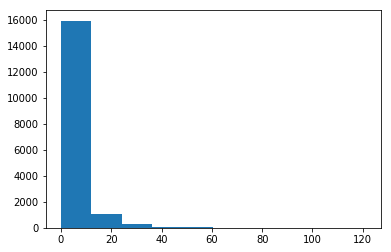

In [9]:

plt.hist(catLens)
np.save('{}/catLens2020all.npy'.format(dataDir), np.array(catLens))
masterCategoryPoolAll = [item for sublist in masterCategoryPoolFlat for item in sublist]

total = Counter(masterCategoryPoolAll)


In [10]:
ks = list(total.keys())
vs = total.values()
vs = np.int_(list(vs))
print(len(ks)) # equals to list(set(words))
print(ks[:5])
print(len(vs))
print(vs[:5])
print(type(vs[0]))
print(len(vs))
print(np.where(vs[:5] == 1)[0])

14955
['All articles needing additional references', 'All stub articles', 'Articles needing additional references from September 2014', "Articles with 'species' microformats", 'Articles with short description']
14955
[ 773  109    9  283 2641]
<class 'numpy.int64'>
14955
[]


In [11]:
candidateSystemsIdx = np.where((3 <= vs) & (vs <= 20))[0]
print(len(candidateSystemsIdx))# counts the elements' frequency
print(candidateSystemsIdx[:5])
candidateSystems = [ks[x] for x in candidateSystemsIdx]
candidateSystemsCleaned = [i for i in candidateSystems if not ('Wiki' in i or 'December' in i or 'ISO' in i or 'November' in i or 'October' in i or 'September' in i or 'August' in i or 'July' in i or 'June' in i or 'May' in i or 'April' in i or 'March' in i or 'February' in i or 'January' in i or 'CS1' in i or  'Page' in i or 'page' in i or 'ISBN' in i or 'dates' in i or 'Article' in i or 'article' in i or 'references' in i)]
print(len(candidateSystemsCleaned))
print(candidateSystemsCleaned[:50])
np.save('{0}/domains2020.npy'.format(dataDir), np.asarray(candidateSystemsCleaned))

1833
[ 2  9 25 26 33]
781
['Fungus classes', 'Medicinal plants', 'Poisonous plants', 'Taxa named by Carl Linnaeus', 'Biotechnology', 'Molecular biology', 'RNA', 'Branches of biology', 'History of science by discipline', 'Bacteriology', 'Metabolism', 'Biophysics', 'Cell biology', 'Biomolecules', 'Life sciences industry', 'Immunology', 'Biology-related lists', 'Experiments', 'Biochemistry', 'Philosophy of biology', 'Chemistry', 'Functional groups', 'Organic chemistry', 'Anions', 'Chembox image size set', 'Dietary minerals', 'Physical chemistry', 'Biology and pharmacology of chemical elements', 'Chembox having GHS data', 'Chemical elements', 'Portal templates with redlinked portals', 'IARC Group 2B carcinogens', 'Food science', 'Biological databases', 'Portal templates with all redlinked portals', 'RTT', 'RTTNEURO', 'Companies listed on the New York Stock Exchange', 'Multinational companies headquartered in the United States', 'Semiotics', 'Integral membrane proteins', 'Protein structure'

In [12]:
domains = np.asarray(candidateSystemsCleaned)
domainsSet = set(candidateSystemsCleaned)
mappings = {}
categoriesUpdated = {}
for i, categoryList in enumerate(masterCategoryPoolFlat):
    jointMappings = domainsSet.intersection(set(categoryList))
    if jointMappings:
        categoriesUpdated[i] = categories[i]
        print(categories[i])
        mappings[i] = [np.where(domains == x)[0][0] for x in jointMappings]
        print([domains[x] for x in mappings[i]])
        
        

Laboulbeniomycetes
['Fungus classes']
Euphorbia
['Taxa named by Carl Linnaeus', 'Medicinal plants', 'Poisonous plants']
RNA
['Biotechnology', 'RNA', 'Molecular biology']
Anatomy
['Branches of biology']
History_of_medicine
['History of science by discipline']
Bacteriology
['Bacteriology']
Metabolism
['Metabolism']
Microbiology
['Branches of biology']
Membrane_biology
['Biophysics']
Proteins
['Molecular biology']
Cell_biology
['Cell biology', 'Molecular biology']
Enzymes
['Biomolecules', 'Metabolism']
DNA
['Biotechnology']
Molecular_biology
['Cell biology', 'Molecular biology']
Biotechnology
['Life sciences industry', 'Biotechnology']
Immune_system
['Immunology']
Immunology
['Immunology']
Human_cells
['Biology-related lists']
Laboratory_techniques
['Experiments']
Biochemistry
['Biotechnology', 'Biochemistry', 'Molecular biology']
Developmental_biology
['Philosophy of biology']
Digestive_system
['Metabolism']
Stereochemistry
['Chemistry']
Functional_groups
['Organic chemistry', 'Functiona

['Lists of association football players by club']
Newport_County_A.F.C._players
['Lists of association football players by club in Wales']
Stoke_City_F.C._seasons
['English football club seasons']
Crewe_Alexandra_F.C._players
['Incomplete sports lists']
Port_Vale_F.C._seasons
['English football club seasons']
Association_football_terminology
['Glossaries of sports']
Swansea_City_A.F.C._players
['Lists of association football players by club in Wales']
Cardiff_City_F.C._players
['Lists of association football players by club in Wales']
Bristol_City_F.C._players
['Bristol-related lists']
Bristol_Rovers_F.C._players
['Bristol-related lists']
Blackpool_F.C._seasons
['English football club seasons']
Members_of_the_Order_of_the_British_Empire
['Orders of chivalry of the United Kingdom', 'Orders of chivalry awarded to heads of state, consorts and sovereign family members']
Hamilton_Academical_F.C._players
['Lists of association football players by club in Scotland']
Inverness_Caledonian_Thist

['Management by type']
Health_informatics
['Health informatics', 'Citation overkill']
Medical_informatics
['Health informatics', 'Citation overkill']
Taxation
['Egyptian inventions']
Types_of_business_entity
['Types of business entity', 'Business law', 'Corporate law', 'Legal entities']
Actuarial_science
['Applied statistics', 'Demography', 'Formal sciences', 'Actuarial science']
Academics
['School types', 'Academia', 'History of ideas']
Financial_economics
['Actuarial science']
Stock_market
['Dutch inventions', '17th-century introductions', 'Capitalism']
Corporate_finance
['Dutch inventions', '17th-century introductions']
Investment_banks
['Dutch inventions', 'Banking terms']
Banking
['Italian inventions', 'Banks', 'Legal entities']
Mathematical_finance
['Applied statistics']
Multinational_companies
['Dutch inventions']
Historical_novels
['Literary genres']
Mystery_novels
['Literary genres']
Thriller_novels
['Thriller genres', 'Television genres', 'Literary genres']
Online_magazines
[

['Wildlife by country']
Neoregelia
['Bromeliaceae genera']
Vriesea
['Bromeliaceae genera', 'Epiphytes']
Urdu_poets
['Incomplete literature lists', 'Lists of poets by language']
Muhajir_people
['Islamic terminology', 'Social groups of Sindh', 'Social groups of Pakistan', 'Ethnic groups in Pakistan', 'Ethnic groups in India', 'Cultural assimilation']
Reduviidae
['Taxa named by Pierre André Latreille']
Hungarian_painters
['Lists of painters by nationality', 'Lists of artists by nationality']
Hungarian_Jews
['Webarchive template webcite links']
Old_Salopians
['Lists of English people by school affiliation']
Electronic_music
['20th-century music genres', 'Audio engineering', 'New media', 'Sound', '21st-century music genres', 'Popular music']
Women_composers
['Lists of composers', 'Women in music']
Russian_composers
['Lists of composers by nationality']
Soviet_composers
['Lists of composers by nationality']
French_composers
['Lists of composers by nationality', 'Lists of French people by occ

In [13]:
with open('{0}/categories_to_domains2020.p'.format(dataDir), 'wb') as pfile:
    pickle.dump(mappings, pfile)

In [14]:
print(categoriesUpdated)

with open('{0}/categories_to_names2020.p'.format(dataDir), 'wb') as pfile:
    pickle.dump(categoriesUpdated, pfile)

{5: 'Laboulbeniomycetes', 13: 'Euphorbia', 32: 'RNA', 33: 'Anatomy', 34: 'History_of_medicine', 35: 'Bacteriology', 38: 'Metabolism', 39: 'Microbiology', 40: 'Membrane_biology', 41: 'Proteins', 42: 'Cell_biology', 43: 'Enzymes', 44: 'DNA', 45: 'Molecular_biology', 47: 'Biotechnology', 48: 'Immune_system', 49: 'Immunology', 50: 'Human_cells', 51: 'Laboratory_techniques', 52: 'Biochemistry', 53: 'Developmental_biology', 58: 'Digestive_system', 60: 'Stereochemistry', 63: 'Functional_groups', 64: 'Organic_chemistry', 65: 'Chemical_reactions', 66: 'Chlorides', 68: 'Physical_chemistry', 70: 'Potassium_compounds', 72: 'IARC_Group_2B_carcinogens', 74: 'Food_additives', 76: 'Sodium_compounds', 78: 'Sequenced_genomes', 82: 'Physiology', 83: 'Carboxylic_acids', 84: 'Medical_Subject_Headings', 86: 'Alkenes', 87: 'Nutrition', 88: 'Food_science', 90: 'Pharmacology', 92: 'Lactams', 93: 'Amines', 99: 'Autoimmune_diseases', 102: 'Eli_Lilly_and_Company', 103: 'Medical_signs', 104: 'Ketones', 105: 'Alcoh

In [15]:
domainDict = {}
for i, domain in enumerate(domains):
    print(domain)
    domainDict[i] = domain
    
with open('{0}/domains_to_names2020.p'.format(dataDir), 'wb') as pfile:
    pickle.dump(domainDict, pfile)
    
print(domainDict)

Fungus classes
Medicinal plants
Poisonous plants
Taxa named by Carl Linnaeus
Biotechnology
Molecular biology
RNA
Branches of biology
History of science by discipline
Bacteriology
Metabolism
Biophysics
Cell biology
Biomolecules
Life sciences industry
Immunology
Biology-related lists
Experiments
Biochemistry
Philosophy of biology
Chemistry
Functional groups
Organic chemistry
Anions
Chembox image size set
Dietary minerals
Physical chemistry
Biology and pharmacology of chemical elements
Chembox having GHS data
Chemical elements
Portal templates with redlinked portals
IARC Group 2B carcinogens
Food science
Biological databases
Portal templates with all redlinked portals
RTT
RTTNEURO
Companies listed on the New York Stock Exchange
Multinational companies headquartered in the United States
Semiotics
Integral membrane proteins
Protein structure
Protein families
Disability
Environmental social science
Epidemiology
Chemical engineering
Engineering disciplines
Amine solvents
Chembox having DSD da